<a href="https://colab.research.google.com/github/IdajiliJohnOjochegbe/Human-orientation-in-an-image/blob/main/Detecting_the_Orientation_of_a_Person_in_a_Picture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# DATA COLLECTION

In [ ]:
from PIL import Image
import os
import random

# Directories
input_dir = '/content/drive/MyDrive/Research/Data collection/Real images/thumbnails128x128'
upright_dir = 'dataset/upright'
upside_down_dir = 'dataset/upside_down'

# Create directories if they don't exist
os.makedirs(upright_dir, exist_ok=True)
os.makedirs(upside_down_dir, exist_ok=True)

# Load images
images = [img for img in os.listdir(input_dir) if img.endswith('.jpg') or img.endswith('.png')]

# Shuffle images
random.shuffle(images)

# Ensure we have enough images
assert len(images) >= 2000, "Not enough images in the input directory"

# Split into upright and upside down
upright_images = images[:1000]
upside_down_images = images[1000:2000]

# Save images
for img_name in upright_images:
    img_path = os.path.join(input_dir, img_name)
    img = Image.open(img_path)
    img.save(os.path.join(upright_dir, img_name))

for img_name in upside_down_images:
    img_path = os.path.join(input_dir, img_name)
    img = Image.open(img_path)
    rotated_img = img.rotate(180)
    rotated_img.save(os.path.join(upside_down_dir, img_name))

# Count the number of images in each directory
num_upright = len(os.listdir(upright_dir))
num_upside_down = len(os.listdir(upside_down_dir))

print(f"Number of upright images: {num_upright}")
print(f"Number of upside-down images: {num_upside_down}")


Number of upright images: 1000
Number of upside-down images: 1000


# EXPLORATORY DATA ANALYSIS(EDA)

Number of upright images: 1000
Number of upside-down images: 1000
Upright Images:


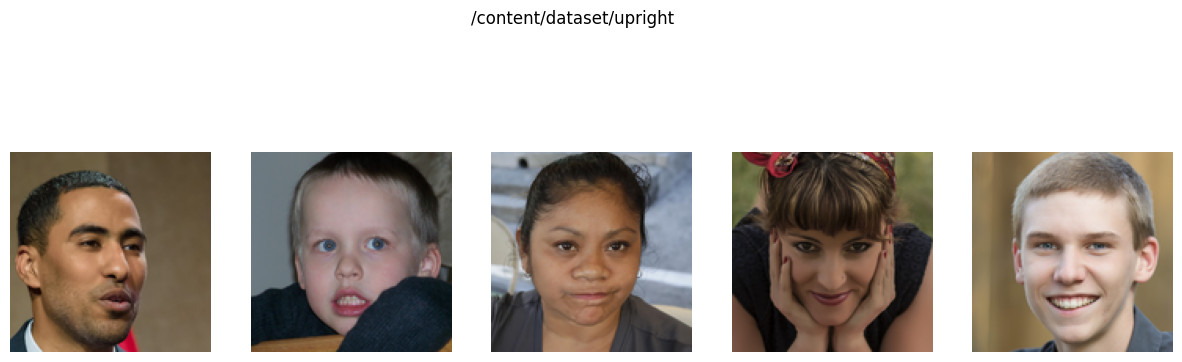

Upside-down Images:


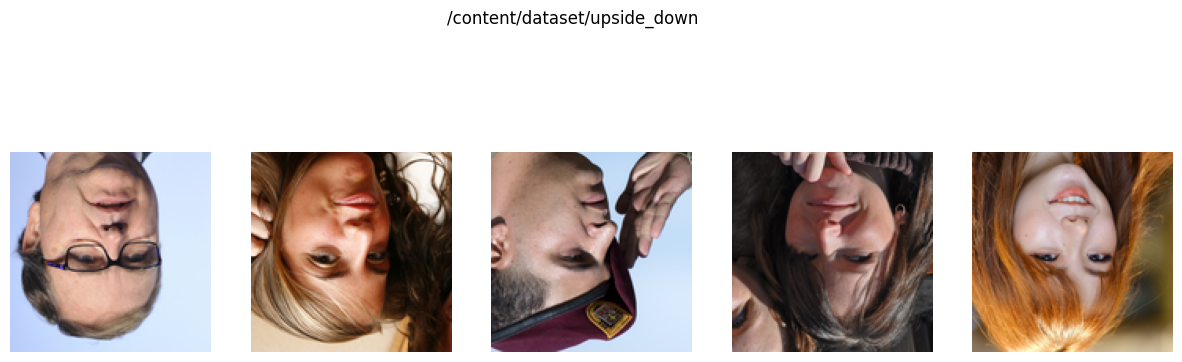

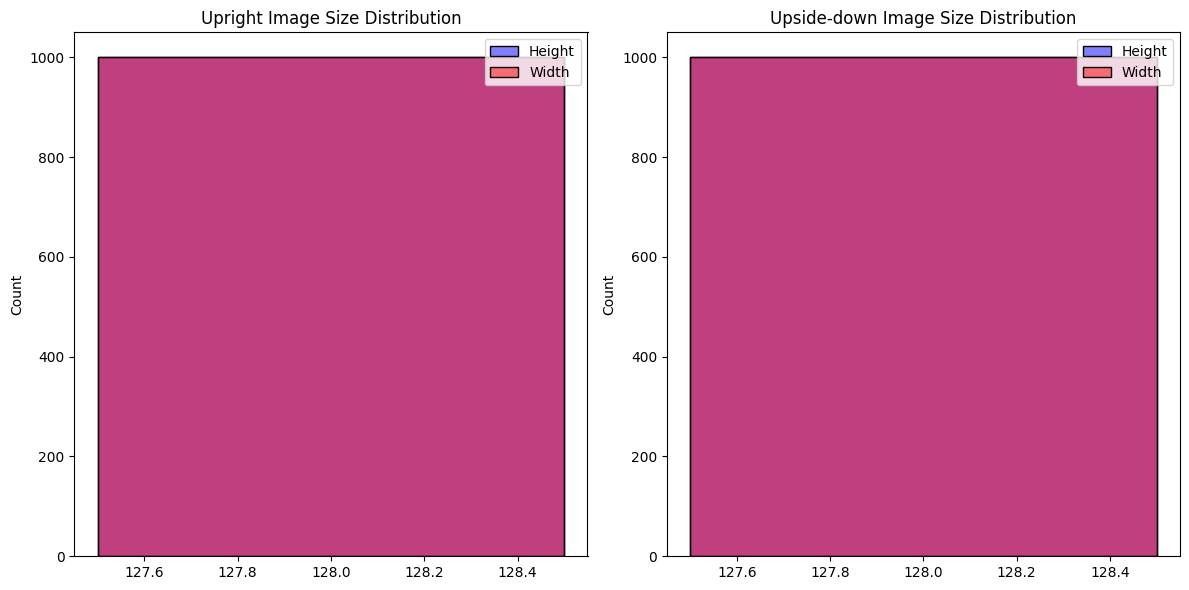

In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

# Directories
upright_dir = '/content/dataset/upright'
upside_down_dir = '/content/dataset/upside_down'

# Load image file names
upright_images = [img for img in os.listdir(upright_dir) if img.endswith(('.jpg', '.png'))]
upside_down_images = [img for img in os.listdir(upside_down_dir) if img.endswith(('.jpg', '.png'))]

# Print basic statistics
print(f"Number of upright images: {len(upright_images)}")
print(f"Number of upside-down images: {len(upside_down_images)}")

# Function to load and display images
def display_images(images, title, num_images=5):
    plt.figure(figsize=(15, 5))
    for i, img_name in enumerate(images[:num_images]):
        img_path = os.path.join(title, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Display some sample images from each class
print("Upright Images:")
display_images(upright_images, upright_dir, num_images=5)

print("Upside-down Images:")
display_images(upside_down_images, upside_down_dir, num_images=5)

# Image size distribution
def image_size_distribution(image_files, directory):
    heights = []
    widths = []
    for img_name in image_files:
        img_path = os.path.join(directory, img_name)
        img = cv2.imread(img_path)
        h, w, _ = img.shape
        heights.append(h)
        widths.append(w)
    return heights, widths

upright_heights, upright_widths = image_size_distribution(upright_images, upright_dir)
upside_down_heights, upside_down_widths = image_size_distribution(upside_down_images, upside_down_dir)

# Plot image size distribution
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(upright_heights, color='blue', kde=True, label='Height')
sns.histplot(upright_widths, color='red', kde=True, label='Width')
plt.title('Upright Image Size Distribution')
plt.legend()

plt.subplot(1, 2, 2)
sns.histplot(upside_down_heights, color='blue', kde=True, label='Height')
sns.histplot(upside_down_widths, color='red', kde=True, label='Width')
plt.title('Upside-down Image Size Distribution')
plt.legend()

plt.tight_layout()
plt.show()


# FEATURE ENGINEERING

In [ ]:
import os
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

# Directories
upright_dir = '/content/dataset/upright'
upside_down_dir = '/content/dataset/upside_down'

# Load pre-trained ResNet50 model + higher level layers
base_model = ResNet50(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.get_layer('avg_pool').output)

# Image size for ResNet50
img_size = (224, 224)

# Function to load and preprocess image
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

# Function to extract features from directory
def extract_features(directory):
    features = []
    labels = []
    for label, class_dir in enumerate(['upright', 'upside_down']):
        class_path = os.path.join(directory, class_dir)
        for img_name in os.listdir(class_path):
            if img_name.endswith(('.jpg', '.png')):
                img_path = os.path.join(class_path, img_name)
                img_array = load_and_preprocess_image(img_path)
                feature = model.predict(img_array)
                features.append(feature.flatten())
                labels.append(label)
    return np.array(features), np.array(labels)

# Extract features and labels
features, labels = extract_features('/content/dataset')

# Save the features and labels to disk
np.save('/content/features.npy', features)
np.save('/content/labels.npy', labels)

print("Feature extraction complete.")
print(f"Features shape: {features.shape}")
print(f"Labels shape: {labels.shape}")


1/1 [==============================] - 0s 34ms/step
Feature extraction complete.
Features shape: (2000, 2048)
Labels shape: (2000,)


# LOAD THE MODEL

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load pre-trained ResNet50 model without classification layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom dense layers for classification
x = Flatten()(base_model.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
print(model.summary())


94765736/94765736 [==============================] - 1s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                       

# SPLITTING THE DATASET TO TRAINING,VALIDATION AND TEST SETS

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define data generators for training, validation, and test sets
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

# Set batch size and image dimensions
batch_size = 32
img_height, img_width = 224, 224

# Load and preprocess training data
train_generator = train_datagen.flow_from_directory(
    '/content/dataset',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training')

# Load and preprocess validation data
validation_generator = train_datagen.flow_from_directory(
    '/content/dataset',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation')

# Load and preprocess test data
test_generator = test_datagen.flow_from_directory(
    '/content/dataset',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary')


Found 1600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


# Get a batch of images and labels from the training generator

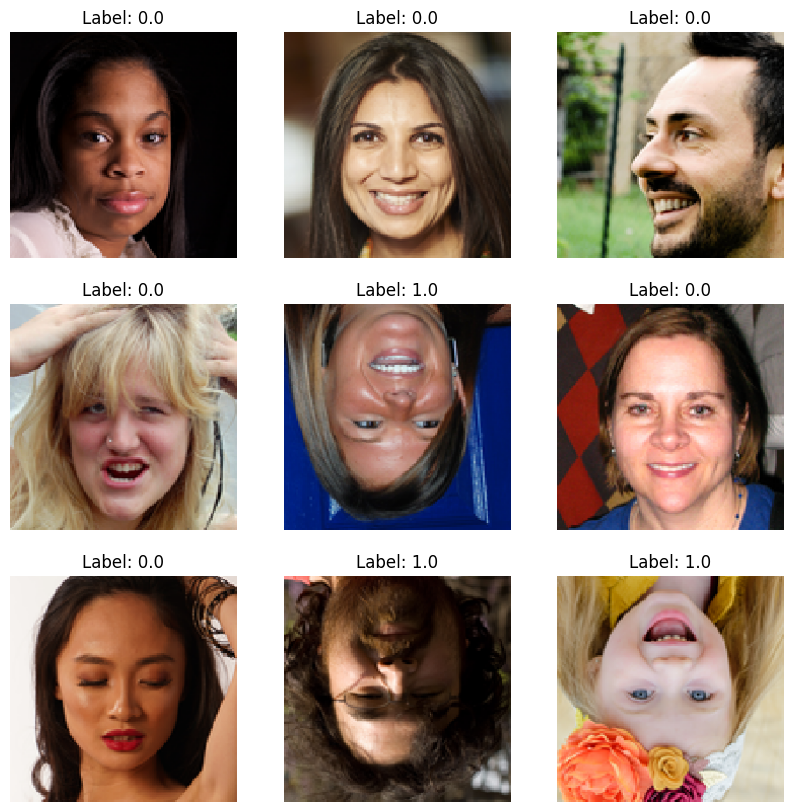

In [ ]:
import matplotlib.pyplot as plt

# Get a batch of images and labels from the training generator
images, labels = next(train_generator)

# Plot the first few images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(f'Label: {labels[i]}')
    plt.axis("off")
plt.show()


# Define the number of training and validation steps per epoch

Epoch 1/50
50/50 [==============================] - 28s 427ms/step - loss: 6.5443 - accuracy: 0.5569 - val_loss: 0.2291 - val_accuracy: 0.9219
Epoch 2/50
50/50 [==============================] - 22s 436ms/step - loss: 0.7110 - accuracy: 0.7406 - val_loss: 0.2707 - val_accuracy: 0.9661
Epoch 3/50
50/50 [==============================] - 24s 485ms/step - loss: 0.5792 - accuracy: 0.7212 - val_loss: 0.4284 - val_accuracy: 0.8646
Epoch 4/50
50/50 [==============================] - 22s 435ms/step - loss: 0.4898 - accuracy: 0.7663 - val_loss: 0.3930 - val_accuracy: 0.8828
Epoch 5/50
50/50 [==============================] - 22s 437ms/step - loss: 0.4302 - accuracy: 0.8256 - val_loss: 0.3266 - val_accuracy: 0.9661
Epoch 6/50
50/50 [==============================] - 22s 445ms/step - loss: 0.4186 - accuracy: 0.8169 - val_loss: 0.2971 - val_accuracy: 0.9896
Epoch 7/50
50/50 [==============================] - 22s 440ms/step - loss: 0.3911 - accuracy: 0.8456 - val_loss: 0.3367 - val_accuracy: 0.8698

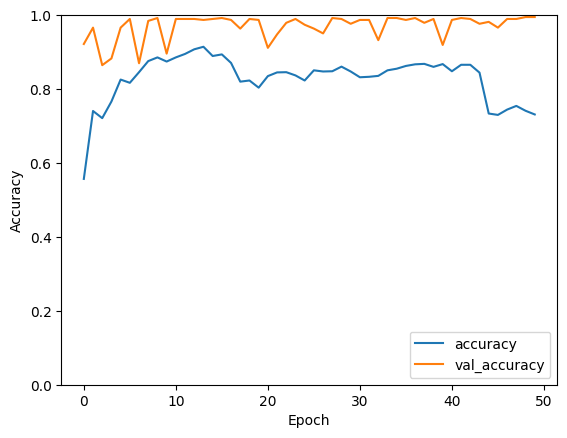

In [ ]:
# Define the number of training and validation steps per epoch
train_steps_per_epoch = train_generator.samples // train_generator.batch_size
val_steps_per_epoch = validation_generator.samples // validation_generator.batch_size

# Compile the model with run_eagerly=True
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'], run_eagerly=True)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    epochs=50,  # Adjust the number of epochs as needed
    validation_data=validation_generator,
    validation_steps=val_steps_per_epoch
)

# Plot training history
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()


# SAVE THE MODEL

In [ ]:
# Save the entire model
model.save('orientation_detection_model.h51')


# TEST ON A NEW UNSEEN IMAGE

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the saved model
model = load_model('orientation_detection_model.h51')

# Function to preprocess a single image
def preprocess_single_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Normalize the pixel values
    return img_array

# Path to the new unseen image for prediction
new_image_path = '/content/drive/MyDrive/R.jpg'

# Preprocess the new unseen image
new_image = preprocess_single_image(new_image_path)

# Make predictions
prediction = model.predict(new_image)

# Output the prediction
if prediction[0] < 0.5:
    print("The image is upright.")
else:
    print("The image is upside-down.")


1/1 [==============================] - 1s 1s/step
The image is upside-down.
